In [37]:
import pandas as pd
import geopandas as gpd
import numpy as np
import requests

# 対象地域情報の読み込み

In [38]:
gdf_jcode = gpd.read_file('data/setup_2000_2020/jcode.geojson')
df_jcode_2020 = pd.read_csv('data/2020/jcode_2020.csv', dtype={'jcode_from': str, 'jcode_to': str})
list_jcode = df_jcode_2020['jcode_from'].to_list()

In [39]:
df_jcode_2020

,jcode_from,jcode_to,都道府県,政令市･郡･支庁･振興局等,市区町村
0,08220,08220,茨城県,NaN,つくば市
1,08224,08224,茨城県,NaN,守谷市
2,08235,08235,茨城県,NaN,つくばみらい市
3,11101,11205,埼玉県,さいたま市,西区
4,11102,11205,埼玉県,さいたま市,北区
...,...,...,...,...,...
114,14205,14205,神奈川県,NaN,藤沢市
115,14207,14207,神奈川県,NaN,茅ヶ崎市
116,14213,14213,神奈川県,NaN,大和市
117,14215,14215,神奈川県,NaN,海老名市


# 地価情報の取得

In [40]:
# pd.read_excel('https://www.mlit.go.jp/totikensangyo/content/001733704.xls')
df_chika = pd.read_excel('sources/001733704.xls', sheet_name='価格推移表', header=0, skiprows=[1])
nayose = pd.read_csv('sources/chika_nayose.csv')

In [41]:
df_chika['Unnamed: 0'] = df_chika['Unnamed: 0'].astype(str)
df_chika['level'] = df_chika['Unnamed: 0'].str[0:1]
df_chika['jcode'] = df_chika['Unnamed: 0'].str[1:6]
df_chika['type'] = df_chika['Unnamed: 0'].str[-2:]
df_chika['name'] = df_chika['Unnamed: 1'].ffill()
df_chika['分類'] = df_chika['Unnamed: 2']
df_chika = df_chika.drop(columns=['Unnamed: 0', 'Unnamed: 1','Unnamed: 2'])
df_chika = df_chika[[
    'level',   'jcode',   'type',    'name',    '分類',
    '昭和50年', '昭和51年', '昭和52年', '昭和53年', '昭和54年', '昭和55年', '昭和56年', '昭和57年',
    '昭和58年', '昭和59年', '昭和60年', '昭和61年', '昭和62年', '昭和63年', '平成元年', '平成2年',
    '平成3年',  '平成4年',  '平成5年',  '平成6年',  '平成7年',  '平成8年',  '平成9年',  '平成10年',
    '平成11年', '平成12年', '平成13年', '平成14年', '平成15年', '平成16年', '平成17年', '平成18年',
    '平成19年', '平成20年', '平成21年', '平成22年', '平成23年', '平成24年', '平成25年', '平成26年',
    '平成27年', '平成28年', '平成29年', '平成30年', '平成31年', '令和2年',  '令和3年',  '令和4年',
    '令和5年',  '令和6年'
]]

In [42]:
df_chika_res = df_chika[['jcode','分類','令和2年']].query('分類 == "住宅"').rename(columns={'令和2年':'res_price'})
df_chika_com = df_chika[['jcode','分類','令和2年']].query('分類 == "商業"').rename(columns={'令和2年':'com_price'})

df_chika_res = df_chika_res.query('jcode in @list_jcode')
df_chika_com = df_chika_com.query('jcode in @list_jcode')

In [43]:
# 2020年居住地平均価格を参考に、300,000円/坪で正規化
print('居住地価格平均値:', np.mean(df_chika_res['res_price'].to_numpy()))
print('居住地価格中央値:', np.median(df_chika_res['res_price'].to_numpy()))

居住地価格平均値: 326116.80672268907
居住地価格中央値: 216200.0


In [44]:
df_chika_res['q_i'] = df_chika_res['res_price']/300000
df_chika_com['Q_j'] = df_chika_com['com_price']/300000
print(df_chika_res['q_i'].mean())
print(df_chika_com['Q_j'].mean())

1.0870560224089636
2.757492997198879


In [45]:
df_q_i = df_chika_res[['jcode','q_i']].round(6)
df_Q_j = df_chika_com[['jcode','Q_j']].round(6)

In [46]:
df_q_i

,jcode,q_i
3577,08220,0.193000
3605,08224,0.284333
3682,08235,0.110000
4921,11101,0.356333
4928,11102,0.583000
...,...,...
6993,14205,0.628000
7007,14207,0.641000
7042,14213,0.625000
7056,14215,0.519667


# 所得w_jの取得

In [47]:
# 所得w_jの取得
URL = 'http://api.e-stat.go.jp/rest/3.0/app/json/getStatsData'
p = {
    'appId':'6f812f8eb28dc679954f0eef1472fca422edc08d',
    'lang':'J',
    'statsDataId':'0003355997',
    # 'metaGetFlg':'N',
    'explanationGetFlg':'N',
    'annotationGetFlg':'N',
    'cdTab':'13-2018',
    'cdCat01':'0',
    'cdCat02':'0',
    # 'lvArea':'2-',
    'cdAreaFrom': '08000',
    'cdAreaTo': '15000',
}

res = requests.get(URL,p)
text = res.json()
print('項目名：',text['GET_STATS_DATA']['STATISTICAL_DATA']['TABLE_INF']['TITLE']['$'])
print('ヒット件数：',text['GET_STATS_DATA']['STATISTICAL_DATA']['RESULT_INF']['TOTAL_NUMBER'])
text['GET_STATS_DATA']['STATISTICAL_DATA']['CLASS_INF']['CLASS_OBJ']

項目名： 家計を主に支える者と住居 世帯の年間収入階級(9区分)，世帯の種類(2区分)，住宅の所有の関係(5区分)別普通世帯数，１世帯当たり人員，１世帯当たり居住室数及び１世帯当たり居住室の畳数－全国，都道府県，市区町村
ヒット件数： 3080


[{'@id': 'tab',
  '@name': '表章項目',
  'CLASS': {'@code': '13-2018',
   '@name': '普通世帯数',
   '@level': '',
   '@unit': '世帯'}},
 {'@id': 'cat01',
  '@name': '世帯の種類',
  'CLASS': {'@code': '0', '@name': '総数', '@level': '1'}},
 {'@id': 'cat02',
  '@name': '住宅の所有の関係',
  'CLASS': {'@code': '0', '@name': '総数', '@level': '1'}},
 {'@id': 'cat03',
  '@name': '世帯の年間収入階級',
  'CLASS': [{'@code': '00', '@name': '総数', '@level': '1'},
   {'@code': '01', '@name': '100万円未満', '@level': '1'},
   {'@code': '02', '@name': '100～200万円未満', '@level': '1'},
   {'@code': '04', '@name': '200～300万円未満', '@level': '1'},
   {'@code': '05', '@name': '300～400万円未満', '@level': '1'},
   {'@code': '06', '@name': '400～500万円未満', '@level': '1'},
   {'@code': '07', '@name': '500～700万円未満', '@level': '1'},
   {'@code': '08', '@name': '700～1000万円未満', '@level': '1'},
   {'@code': '09', '@name': '1000～1500万円未満', '@level': '1'},
   {'@code': '10', '@name': '1500万円以上', '@level': '1'}]},
 {'@id': 'area',
  '@name': '地域',
  'CLASS': [{'@c

In [48]:
df = pd.DataFrame(text['GET_STATS_DATA']['STATISTICAL_DATA']['DATA_INF']['VALUE'])

def parse_wage(x):
   if   x=='01': return 50
   elif x=='02': return 150
   elif x=='04': return 250
   elif x=='05': return 350
   elif x=='06': return 450
   elif x=='07': return 600
   elif x=='08': return 850
   elif x=='09': return 1250
   elif x=='10': return 2000
   else: return 0

df['weight'] = df['@cat03'].apply(parse_wage)
df['num'] = df['$'].astype(int)
df['jcode'] = df['@area']


wm = lambda x: np.average(x, weights=df.loc[x.index, "num"]).round(2)
df_w_j = df.groupby(by='jcode').agg(w_j=("weight", wm)).loc[list_jcode].reset_index()
df_w_j['w_j'] = (df_w_j['w_j']/300).round(6)
df_w_j

,jcode,w_j
0,08220,0.853833
1,08224,1.042900
2,08235,0.771533
3,11101,0.798100
4,11102,0.905800
...,...,...
114,14205,0.882300
115,14207,0.837033
116,14213,0.794767
117,14215,0.886200


# 通勤割合λ_ijの取得

In [49]:
From = '08000'
To = '14999'

URL = 'http://api.e-stat.go.jp/rest/3.0/app/json/getStatsData'
p = {
     'appId':'6f812f8eb28dc679954f0eef1472fca422edc08d',
     'lang':'J',
     'statsDataId':'0003454528',
     'startPosition':'1',
     # 'metaGetFlg':'N',
     'explanationGetFlg':'N',
     'annotationGetFlg':'N',
     'cdCat01':'0',
     # 'cdArea':','.join(list),
     # # 'cdCat02':','.join(list)
     # 'lvArea':'4-',
     'cdAreaFrom': From,
     'cdAreaTo': To,
     # 'lvCat02':'4-',
     'cdCat02From':From,
     'cdCat02To':To,
     }

res = requests.get(URL,p)
text = res.json()
print('項目名：',text['GET_STATS_DATA']['STATISTICAL_DATA']['TABLE_INF']['TITLE']['$'])
print('ヒット件数：',text['GET_STATS_DATA']['STATISTICAL_DATA']['RESULT_INF']['TOTAL_NUMBER'])
text['GET_STATS_DATA']['STATISTICAL_DATA']['CLASS_INF']['CLASS_OBJ']

項目名： 人口 従業・通学市区町村，男女別通勤者数（15歳以上） － 全国，都道府県，市区町村（常住地）
ヒット件数： 135424


[{'@id': 'tab',
  '@name': '表章事項',
  'CLASS': {'@code': '2020_08', '@name': '通勤者数', '@level': '', '@unit': '人'}},
 {'@id': 'cat01',
  '@name': '男女',
  'CLASS': {'@code': '0', '@name': '総数', '@level': '1'}},
 {'@id': 'cat02',
  '@name': '全国［総数］，都道府県，市区町村（従業地・通学地）',
  'CLASS': [{'@code': '08000',
    '@name': '茨城県',
    '@level': '2',
    '@parentCode': '00000'},
   {'@code': '08201', '@name': '水戸市', '@level': '4', '@parentCode': '08000'},
   {'@code': '08202', '@name': '日立市', '@level': '4', '@parentCode': '08000'},
   {'@code': '08203', '@name': '土浦市', '@level': '4', '@parentCode': '08000'},
   {'@code': '08204', '@name': '古河市', '@level': '4', '@parentCode': '08000'},
   {'@code': '08205', '@name': '石岡市', '@level': '4', '@parentCode': '08000'},
   {'@code': '08207', '@name': '結城市', '@level': '4', '@parentCode': '08000'},
   {'@code': '08208', '@name': '龍ケ崎市', '@level': '4', '@parentCode': '08000'},
   {'@code': '08210', '@name': '下妻市', '@level': '4', '@parentCode': '08000'},
   {'@code'

In [50]:
df_1 = pd.DataFrame(text['GET_STATS_DATA']['STATISTICAL_DATA']['DATA_INF']['VALUE'])

p['startPosition'] = '100001'
text = requests.get(URL,p).json()
df_2 = pd.DataFrame(text['GET_STATS_DATA']['STATISTICAL_DATA']['DATA_INF']['VALUE'])
df = pd.concat([df_1,df_2])

df_commute_ij = pd.DataFrame(0,columns=list_jcode,index=list_jcode)
for i in df.itertuples():
    if (i[3] not in list_jcode)|(i[4] not in list_jcode): continue
    if i[7] in ['-',None]: 
        df_commute_ij.at[i[4],i[3]]=0
    else: 
        if int(i[7]) > 100: df_commute_ij.at[i[4],i[3]]=int(i[7])

In [51]:
df_commute_ij

,08220,08224,08235,11101,11102,11103,11104,11105,11106,11107,...,14137,14151,14152,14153,14204,14205,14207,14213,14215,14216
08220,63470,1104,2419,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
08224,1909,8624,1680,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
08235,3193,2228,5576,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11101,0,0,0,10472,1943,2787,452,1178,578,886,...,0,0,0,0,0,0,0,0,0,0
11102,0,0,0,1382,19280,4582,1169,1676,378,1788,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14205,0,0,0,0,0,0,0,0,0,0,...,350,176,472,828,8978,75307,4972,3498,1748,686
14207,0,0,0,0,0,0,0,0,0,0,...,0,107,252,262,2223,11845,31932,562,986,258
14213,0,0,0,0,0,0,0,0,0,0,...,478,313,978,2243,423,4326,298,28309,2013,3377
14215,0,0,0,0,0,0,0,0,0,0,...,246,262,737,952,128,1473,446,1897,16821,2122


# 世帯あたり子供の数n_ijの取得

In [52]:
URL = 'http://api.e-stat.go.jp/rest/3.0/app/json/getStatsData'
p = {'appId':'6f812f8eb28dc679954f0eef1472fca422edc08d',
     'lang':'J',
     'statsDataId':'0003445162',
     # 'metaGetFlg':'N',
     'explanationGetFlg':'N',
     'annotationGetFlg':'N',
     'cdCat01':'0',
     # 'cdArea':','.join(jcode),
     # # 'cdCat02':','.join(jcode)
     # 'lvArea':'5-',
     'cdAreaFrom': From,
     'cdAreaTo': To,
     'cdCat02' :'0',
     'cdCat03' :'01,02,03'
     }

res = requests.get(URL,p)
text = res.json()
print('項目名：',text['GET_STATS_DATA']['STATISTICAL_DATA']['TABLE_INF']['TITLE']['$'])
print('ヒット件数：',text['GET_STATS_DATA']['STATISTICAL_DATA']['RESULT_INF']['TOTAL_NUMBER'])
text['GET_STATS_DATA']['STATISTICAL_DATA']['CLASS_INF']['CLASS_OBJ']

項目名： 総人口・総世帯数・男女・年齢・配偶関係 男女，年齢（5歳階級），国籍総数か日本人別人口－全国，都道府県，市区町村（2000年（平成12年）市区町村含む）
ヒット件数： 1845


[{'@id': 'tab',
  '@name': '表章事項',
  'CLASS': {'@code': '2020_01', '@name': '人口', '@level': '', '@unit': '人'}},
 {'@id': 'cat01',
  '@name': '国籍総数か日本人',
  'CLASS': {'@code': '0', '@name': '国籍総数', '@level': '1'}},
 {'@id': 'cat02',
  '@name': '男女',
  'CLASS': {'@code': '0', '@name': '総数', '@level': '1'}},
 {'@id': 'cat03',
  '@name': '年齢',
  'CLASS': [{'@code': '01', '@name': '0～4歳', '@level': '1'},
   {'@code': '02', '@name': '5～9歳', '@level': '1'},
   {'@code': '03', '@name': '10～14歳', '@level': '1'}]},
 {'@id': 'area',
  '@name': '全国，都道府県，市区町村（2000年市区町村含む）',
  'CLASS': [{'@code': '08000',
    '@name': '茨城県',
    '@level': '2',
    '@parentCode': '00000'},
   {'@code': '08201', '@name': '水戸市', '@level': '4', '@parentCode': '08000'},
   {'@code': '0820B',
    '@name': '（旧：水戸市）',
    '@level': '7',
    '@parentCode': '08000'},
   {'@code': '08305',
    '@name': '（旧：内原町）',
    '@level': '7',
    '@parentCode': '08000'},
   {'@code': '08202', '@name': '日立市', '@level': '4', '@parentCode': 

In [53]:
df = pd.DataFrame(text['GET_STATS_DATA']['STATISTICAL_DATA']['DATA_INF']['VALUE'])
df_children_i = pd.DataFrame(0,index=list_jcode,columns=[0])
for i in df.itertuples():
    try: 
        if i[8] == '-': pass
        else: df_children_i.at[i[5],0] += int(i[8])
    except: pass

arr_children_ij = df_children_i.to_numpy() * df_commute_ij.to_numpy()/df_commute_ij.sum(axis=1).to_numpy().reshape(1,-1).T
df_children_ij = pd.DataFrame(arr_children_ij,index=list_jcode, columns=list_jcode)
df_children_ij = (df_children_ij).fillna(0)

In [54]:
df_children_ij

,08220,08224,08235,11101,11102,11103,11104,11105,11106,11107,...,14137,14151,14152,14153,14204,14205,14207,14213,14215,14216
08220,29194.346123,507.807754,1112.669344,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
08224,934.230082,4220.429664,822.161623,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
08235,1614.401183,1126.491023,2819.261196,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
11101,0.000000,0.000000,0.000000,4251.100922,788.759462,1131.380660,183.489077,478.208259,234.638687,359.671067,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
11102,0.000000,0.000000,0.000000,492.779101,6874.660682,1633.801621,416.829789,597.610545,134.783285,637.546333,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14205,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,126.098387,63.409475,170.052682,298.312756,3234.603769,27131.689242,1791.317659,1260.263308,629.771373,247.152839
14207,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,43.647917,102.796964,106.876208,906.816072,4831.865216,13025.843822,229.253546,402.213516,105.244510
14213,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,172.715065,113.095848,353.379359,810.460024,152.841993,1563.107473,107.675919,10228.851008,727.354448,1220.206643
14215,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,109.955961,117.107568,329.420906,425.520628,57.212858,658.394837,199.351050,847.912427,7518.574032,948.481903


# 交通費用の算出

In [55]:
gdf_gov = gpd.read_file('data/setup_2000_2020/gov_poi.geojson',dtypes={'jcode':str})

In [56]:
df_time = pd.read_excel('sources/e-2_H30.xlsx', skiprows=[0,1,2])
df_time['発ゾーン'] = df_time['発ゾーン'].str.strip(':')
df_time['着ゾーン'] = df_time['着ゾーン'].str.strip(':')
ptcode = gdf_gov['H30'].tolist()
df_time = df_time[(df_time['発ゾーン'].isin(ptcode))&(df_time['着ゾーン'].isin(ptcode))]

In [57]:
df_time = df_time.merge(gdf_gov[['jcode','H30']], left_on='発ゾーン', right_on='H30', how='left').rename(columns={'jcode':'ori_jcode'}).drop(columns='H30')
df_time = df_time.merge(gdf_gov[['jcode','H30']], left_on='着ゾーン', right_on='H30', how='left').rename(columns={'jcode':'dst_jcode'}).drop(columns='H30')

df_time = df_time.sort_values(['ori_jcode', 'dst_jcode'])
df_time['鉄道'] = df_time['鉄道'].where(df_time['鉄道'] !=0.0, df_time[['バス','自動車']].apply(lambda x: np.round(np.mean(x),2), axis=1))

In [58]:
df_time_ij = (df_time.pivot_table(values='鉄道', index='ori_jcode', columns='dst_jcode', fill_value=540)/(60*24)).round(6)

In [59]:
df_time_ij

dst_jcode,08220,08224,08235,11203,11204,11205,11208,11219,11220,11221,...,14135,14136,14137,14204,14205,14207,14209,14213,14215,14216
ori_jcode,,,,,,,,,,,,,,,,,,,,,
08220,0.016507,0.041667,0.020833,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,...,0.083333,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000
08224,0.020833,0.009514,0.020833,0.375000,0.375000,0.375000,0.375000,0.104167,0.375000,0.375000,...,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000
08235,0.020833,0.020833,0.004167,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,...,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000
11203,0.375000,0.375000,0.375000,0.041667,0.033736,0.041667,0.375000,0.375000,0.026667,0.375000,...,0.062500,0.375000,0.375000,0.111111,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000
11204,0.375000,0.375000,0.375000,0.043181,0.019076,0.020354,0.027778,0.049465,0.017715,0.041667,...,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14207,0.375000,0.375000,0.375000,0.375000,0.094444,0.375000,0.375000,0.375000,0.096528,0.375000,...,0.375000,0.375000,0.375000,0.040111,0.031451,0.019722,0.026465,0.053465,0.043979,0.055556
14209,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,...,0.375000,0.375000,0.041667,0.375000,0.375000,0.023472,0.173847,0.042424,0.059292,0.082722
14213,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,...,0.045000,0.030097,0.041632,0.051389,0.031167,0.051215,0.051972,0.024278,0.035611,0.039951


In [60]:
df_time_ij_sim = df_time_ij
df_time_ij_sim.loc['13101':'13123',:] = df_time_ij_sim.loc['13101':'13123',:]*0.50
df_time_ij_sim.loc[:,'13101':'13123'] = df_time_ij_sim.loc[:,'13101':'13123']*0.50
df_time_ij_sim.loc['13101':'13123','13101':'13123'] = df_time_ij_sim.loc['13101':'13123','13101':'13123']/0.50
df_time_ij_sim

dst_jcode,08220,08224,08235,11203,11204,11205,11208,11219,11220,11221,...,14135,14136,14137,14204,14205,14207,14209,14213,14215,14216
ori_jcode,,,,,,,,,,,,,,,,,,,,,
08220,0.016507,0.041667,0.020833,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,...,0.083333,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000
08224,0.020833,0.009514,0.020833,0.375000,0.375000,0.375000,0.375000,0.104167,0.375000,0.375000,...,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000
08235,0.020833,0.020833,0.004167,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,...,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000
11203,0.375000,0.375000,0.375000,0.041667,0.033736,0.041667,0.375000,0.375000,0.026667,0.375000,...,0.062500,0.375000,0.375000,0.111111,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000
11204,0.375000,0.375000,0.375000,0.043181,0.019076,0.020354,0.027778,0.049465,0.017715,0.041667,...,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14207,0.375000,0.375000,0.375000,0.375000,0.094444,0.375000,0.375000,0.375000,0.096528,0.375000,...,0.375000,0.375000,0.375000,0.040111,0.031451,0.019722,0.026465,0.053465,0.043979,0.055556
14209,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,...,0.375000,0.375000,0.041667,0.375000,0.375000,0.023472,0.173847,0.042424,0.059292,0.082722
14213,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,...,0.045000,0.030097,0.041632,0.051389,0.031167,0.051215,0.051972,0.024278,0.035611,0.039951


運賃の参考
初乗り:　150円
https://www.jreast.co.jp/press/2019/20190702.pdf
距離運賃: 17.8円/km
https://www.jreast.co.jp/ryokaku/02_hen/03_syo/02_setsu/04.html

In [61]:
gdf_gov = gdf_gov.to_crs(epsg=6677)
list_gov = gdf_gov['jcode'].to_list()
distance_matrix = gdf_gov.geometry.apply(lambda x: gdf_gov.distance(x)).values
distance_matrix = np.where(distance_matrix/1000 > 140/17.8, distance_matrix/1000*17.8, 140)
distance_matrix = distance_matrix * (22*12) / 3000000
distance_matrix = np.round(distance_matrix, 5)
df_cost_ij = pd.DataFrame(distance_matrix,index=list_gov, columns=list_gov)

In [62]:
df_cost_ij

,08220,08224,08235,11203,11204,11205,11208,11219,11220,11221,...,14135,14136,14137,14204,14205,14207,14209,14213,14215,14216
08220,0.01232,0.02705,0.02169,0.06911,0.07217,0.07035,0.09906,0.07067,0.07248,0.05900,...,0.10861,0.11111,0.11608,0.15258,0.15371,0.16136,0.13353,0.13565,0.14728,0.14021
08224,0.02705,0.01232,0.01232,0.04343,0.04927,0.04964,0.07638,0.05420,0.05078,0.03253,...,0.08215,0.08438,0.08986,0.12556,0.12667,0.13442,0.10788,0.10897,0.12069,0.11376
08235,0.02169,0.01232,0.01232,0.05182,0.05817,0.05856,0.08525,0.06276,0.05972,0.04056,...,0.08990,0.09183,0.09776,0.13172,0.13324,0.14140,0.11606,0.11645,0.12824,0.12144
11203,0.06911,0.04343,0.05182,0.01232,0.01453,0.02182,0.03621,0.03482,0.01919,0.01232,...,0.03996,0.04322,0.04707,0.08855,0.08793,0.09401,0.06452,0.06725,0.07861,0.07135
11204,0.07217,0.04927,0.05817,0.01453,0.01232,0.01232,0.02716,0.02151,0.01232,0.02350,...,0.04357,0.04817,0.04888,0.09519,0.09333,0.09776,0.06339,0.07013,0.08057,0.07295
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14207,0.16136,0.13442,0.14140,0.09401,0.09776,0.10443,0.08145,0.11498,0.10060,0.10261,...,0.05446,0.05079,0.04905,0.02038,0.01234,0.01232,0.04152,0.02775,0.01966,0.02690
14209,0.13353,0.10788,0.11606,0.06452,0.06339,0.06854,0.04191,0.07713,0.06505,0.07550,...,0.02810,0.02933,0.01964,0.05030,0.04375,0.04152,0.01232,0.01892,0.02186,0.01520
14213,0.13565,0.10897,0.11645,0.06725,0.07013,0.07669,0.05427,0.08727,0.07288,0.07665,...,0.02731,0.02462,0.02131,0.03185,0.02625,0.02775,0.01892,0.01232,0.01232,0.01232
14215,0.14728,0.12069,0.12824,0.07861,0.08057,0.08674,0.06237,0.09663,0.08301,0.08829,...,0.03870,0.03643,0.03184,0.03132,0.02351,0.01966,0.02186,0.01232,0.01232,0.01232


In [63]:
df_cost_ij.index.unique()

Index(['08220', '08224', '08235', '11203', '11204', '11205', '11208', '11219',
       '11220', '11221',
       ...
       '14135', '14136', '14137', '14204', '14205', '14207', '14209', '14213',
       '14215', '14216'],
      dtype='object', length=111)

# 商業地比率の算出

住宅件数と事業所数から算出
- 令和3年延べ面積比率（区別）
  - https://www.toshiseibi.metro.tokyo.lg.jp/seisaku/tochi_c/pdf/tochi_r3/tochi_r3_67.csv
- 事業所数
  - https://api.e-stat.go.jp/rest/3.0/app/getStatsData?cdCat01=A%2CB%2CC%2CD%2CE%2CF%2CG%2CH%2CI%2CJ%2CK%2CL%2CM%2CN%2CO%2CP%2CQ%2CR&cdTab=102-2021&cdArea=13101%2C13102%2C13103%2C13104%2C13105%2C13106%2C13107%2C13108%2C13109%2C13110%2C13111%2C13112%2C13113%2C13114%2C13115%2C13116%2C13117%2C13118%2C13119%2C13120%2C13121%2C13122%2C13123&appId=&lang=J&statsDataId=0004005684&metaGetFlg=Y&cntGetFlg=N&explanationGetFlg=Y&annotationGetFlg=Y&sectionHeaderFlg=1&replaceSpChars=0
- 
- 住宅数
  - https://api.e-stat.go.jp/rest/3.0/app/getStatsData?cdCat01=1%2C2%2C3%2C4&cdCat02=00&cdArea=13101%2C13102%2C13103%2C13104%2C13105%2C13106%2C13107%2C13108%2C13109%2C13110%2C13111%2C13112%2C13113%2C13114%2C13115%2C13116%2C13117%2C13118%2C13119%2C13120%2C13121%2C13122%2C13123&cdCat03=0&appId=&lang=J&statsDataId=0003355607&metaGetFlg=Y&cntGetFlg=N&explanationGetFlg=Y&annotationGetFlg=Y&sectionHeaderFlg=1&replaceSpChars=0
- 

In [64]:
# df_weight = pd.read_csv('https://www.toshiseibi.metro.tokyo.lg.jp/seisaku/tochi_c/pdf/tochi_5/tochi_5list_67.csv', encoding='CP932')
df_weight = pd.read_csv('https://www.toshiseibi.metro.tokyo.lg.jp/seisaku/tochi_c/pdf/tochi_r3/tochi_r3_61.csv', encoding='CP932')

A農業、林業: なし

B漁業: なし

C鉱業、採石業、砂利採取業: なし

D建設業: なし

E製造業: BI-1, BI-2

F電気・ガス・熱供給・水道業 : BP-4

G情報通信業: BC-1

H運輸業、郵便業: BI-3

I卸売業、小売業: BC-2, BC-3, BC-4, BC-5

J金融業、保険業: BC-1

K不動産業、物品賃貸業: BC-1

L学術研究、専門・技術サービス業: BC-1

M宿泊業、飲食サービス業: BC-2, BC-3, BC-4, BC-5

N生活関連サービス業、娯楽業: BC-2, BC-3, BC-4, BC-5

O教育、学習支援業: BP-2

P医療、福祉: BP-3

Q複合サービス事業: BC-2, BC-3, BC-4, BC-5

Rサービス業（他に分類されないもの）: BC-2, BC-3, BC-4, BC-5

＊S公務（他に分類されるものを除く）: BP-1

In [65]:
df_weight_i= pd.DataFrame(
    0,
    index=list_jcode,
    columns=['BP-1','BP-2','BP-3','BP-4','BC-1','BC-2345','BR-1','BR-2','BI-12','BI-3']
)

In [66]:
import statsmodels.api as sm
URL = 'http://api.e-stat.go.jp/rest/3.0/app/json/getStatsData'
p = {'appId':'6f812f8eb28dc679954f0eef1472fca422edc08d',
     'lang':'J',
     'statsDataId':'0004005684',
     'explanationGetFlg':'N',
     'annotationGetFlg':'N',
     'cdCat01':'A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R',
     'cdTab':'102-2021',
     # 'cdArea':','.join(jcode),
     # # 'cdCat02':','.join(jcode)
     # 'lvArea':'5-',
     'cdAreaFrom': From,
     'cdAreaTo': To
     }
res = requests.get(URL,p)
text = res.json()
print('項目名：',text['GET_STATS_DATA']['STATISTICAL_DATA']['TABLE_INF']['TITLE']['$'])
print('ヒット件数：',text['GET_STATS_DATA']['STATISTICAL_DATA']['RESULT_INF']['TOTAL_NUMBER'])
text['GET_STATS_DATA']['STATISTICAL_DATA']['CLASS_INF']['CLASS_OBJ']
df = pd.DataFrame(text['GET_STATS_DATA']['STATISTICAL_DATA']['DATA_INF']['VALUE'])

項目名： 産業(中分類)別民営事業所数、男女別従業者数、常用雇用者数、出向・派遣従業者数及び事業従事者数－全国、都道府県、市区町村
ヒット件数： 6642


In [67]:
for i in df.itertuples():
    try: 
        if i[6] == '-': continue
        else: 
            if i[2]=='E': df_weight_i.at[i[3],'BI-12'] += int(i[6])
            elif i[2]=='F': df_weight_i.at[i[3],'BP-4'] += int(i[6])
            elif i[2]=='G': df_weight_i.at[i[3],'BC-1'] += int(i[6])
            elif i[2]=='H': df_weight_i.at[i[3],'BI-3'] += int(i[6])
            elif i[2]=='I': df_weight_i.at[i[3],'BC-2345'] += int(i[6])
            elif i[2]=='J': df_weight_i.at[i[3],'BC-1'] += int(i[6])
            elif i[2]=='K': df_weight_i.at[i[3],'BC-1'] += int(i[6])
            elif i[2]=='L': df_weight_i.at[i[3],'BC-1'] += int(i[6])
            elif i[2]=='M': df_weight_i.at[i[3],'BC-2345'] += int(i[6])
            elif i[2]=='N': df_weight_i.at[i[3],'BC-2345'] += int(i[6])
            elif i[2]=='O': df_weight_i.at[i[3],'BP-2'] += int(i[6])
            elif i[2]=='P': df_weight_i.at[i[3],'BP-3'] += int(i[6])
            elif i[2]=='Q': df_weight_i.at[i[3],'BC-2345'] += int(i[6])
            elif i[2]=='R': df_weight_i.at[i[3],'BC-2345'] += int(i[6])
    except: continue

In [68]:
URL = 'http://api.e-stat.go.jp/rest/3.0/app/json/getStatsData'
p = {'appId':'6f812f8eb28dc679954f0eef1472fca422edc08d',
     'lang':'J',
     'statsDataId':'0003355607',
     # 'metaGetFlg':'N',
     'explanationGetFlg':'N',
     'annotationGetFlg':'N',
     'cdCat01':'1,2,3,4',
     'cdCat02':'00',
     'cdCat03':'0',
     # 'cdArea':','.join(jcode),
     # # 'cdCat02':','.join(jcode)
     # 'lvArea':'5-',
     'cdAreaFrom': From,
     'cdAreaTo': To
     }
res = requests.get(URL,p)
text = res.json()
print('項目名：',text['GET_STATS_DATA']['STATISTICAL_DATA']['TABLE_INF']['TITLE']['$'])
print('ヒット件数：',text['GET_STATS_DATA']['STATISTICAL_DATA']['RESULT_INF']['TOTAL_NUMBER'])
text['GET_STATS_DATA']['STATISTICAL_DATA']['CLASS_INF']['CLASS_OBJ']
df = pd.DataFrame(text['GET_STATS_DATA']['STATISTICAL_DATA']['DATA_INF']['VALUE'])

項目名： 住宅の種類，建て方，建築の時期，建物の構造，階数 住宅の建て方(4区分)，構造(3区分)，階数(4区分)別住宅数－全国，都道府県，市区町村
ヒット件数： 1228


In [69]:
for i in df.itertuples():
    try: 
        if i[8] == '-': pass
        else: 
            if i[2]=='1': df_weight_i.at[i[5],'BR-1'] += int(i[8])
            else: df_weight_i.at[i[5],'BR-2'] += int(i[8])
    except: pass

In [70]:
URL = 'http://api.e-stat.go.jp/rest/3.0/app/json/getStatsData'
p = {'appId':'6f812f8eb28dc679954f0eef1472fca422edc08d',
     'lang':'J',
     'statsDataId':'0004005640',
     # 'metaGetFlg':'N',
     'explanationGetFlg':'N',
     'annotationGetFlg':'N',
     'cdTab':'102-2021',
     'cdAreaFrom': From,
     'cdAreaTo': To
     }
res = requests.get(URL,p)
text = res.json()
print('項目名：',text['GET_STATS_DATA']['STATISTICAL_DATA']['TABLE_INF']['TITLE']['$'])
print('ヒット件数：',text['GET_STATS_DATA']['STATISTICAL_DATA']['RESULT_INF']['TOTAL_NUMBER'])
text['GET_STATS_DATA']['STATISTICAL_DATA']['CLASS_INF']['CLASS_OBJ']
df = pd.DataFrame(text['GET_STATS_DATA']['STATISTICAL_DATA']['DATA_INF']['VALUE'])

項目名： 経営組織(2区分)別全事業所数、男女別従業者数、1km2当たり事業所数及び従業者数－全国、都道府県、郡・支庁等、市区町村
ヒット件数： 826


In [71]:
for i in df.itertuples():
    try: 
        if i[6] == '-': pass
        else: 
            if i[2]=='0': df_weight_i.at[i[3],'BP-1'] += int(i[6])
            else: df_weight_i.at[i[3],'BP-1'] -= int(i[6])
    except: pass

In [72]:
df_weight_i['all'] = df_weight_i['BP-1']+df_weight_i['BP-2']+df_weight_i['BP-3']+df_weight_i['BP-4']+df_weight_i['BC-1']+df_weight_i['BC-2345']+df_weight_i['BR-1']+df_weight_i['BR-2']+df_weight_i['BI-12']+df_weight_i['BI-3']
df_weight_i['BP-1'] = df_weight_i['BP-1']/df_weight_i['all']
df_weight_i['BP-2'] = df_weight_i['BP-2']/df_weight_i['all']
df_weight_i['BP-3'] = df_weight_i['BP-3']/df_weight_i['all']
df_weight_i['BP-4'] = df_weight_i['BP-4']/df_weight_i['all']
df_weight_i['BC-1'] = df_weight_i['BC-1']/df_weight_i['all']
df_weight_i['BC-2345'] = df_weight_i['BC-2345']/df_weight_i['all']
df_weight_i['BR-1'] = df_weight_i['BR-1']/df_weight_i['all']
df_weight_i['BR-2'] = df_weight_i['BR-2']/df_weight_i['all']
df_weight_i['BI-12'] = df_weight_i['BI-12']/df_weight_i['all']
df_weight_i['BI-3'] = df_weight_i['BI-3']/df_weight_i['all']

In [73]:
tokyo = ['13101','13102','13103','13104','13105','13106','13107','13108','13109','13110','13111','13112','13113','13114','13115','13116','13117','13118','13119','13120','13121','13122','13123']
df_weight_tokyo = df_weight_i.reset_index(names='jcode').query('jcode in @tokyo').reset_index()
df_weight_others = df_weight_i.reset_index(names='jcode').query('jcode not in @tokyo').reset_index()

In [74]:
BP1_res =sm.OLS(df_weight['BP-1／官公庁施設構成比(%)'], df_weight_tokyo['BP-1']).fit()
BP2_res =sm.OLS(df_weight['BP-2／教育文化施設構成比(%)'], df_weight_tokyo['BP-2']).fit()
BP3_res =sm.OLS(df_weight['BP-3／厚生医療施設構成比(%)'], df_weight_tokyo['BP-3']).fit()
BP4_res =sm.OLS(df_weight['BP-4／供給処理施設構成比(%)'], df_weight_tokyo['BP-4']).fit()
BC1_res =sm.OLS(df_weight['BC-1／事務所建築物構成比(%)'], df_weight_tokyo['BC-1']).fit()
BC2345_res =sm.OLS((df_weight['BC-2／専用商業施設構成比(%)']+df_weight['BC-3／住商併用施設構成比(%)']+df_weight['BC-4／宿泊・遊興施設構成比(%)']+df_weight['BC-5／スポーツ・興行施設構成比(%)']), df_weight_tokyo['BC-2345']).fit()
BR1_res =sm.OLS(df_weight['BR-1／独立住宅構成比(%)'], df_weight_tokyo['BR-1']).fit()
BR2_res =sm.OLS(df_weight['BR-2／集合住宅構成比(%)'], df_weight_tokyo['BR-2']).fit()
BI12_res =sm.OLS((df_weight['BI-1／専用工場構成比(%)']+df_weight['BI-2／住居併用工場構成比(%)']), df_weight_tokyo['BI-12']).fit()
BI3_res =sm.OLS(df_weight['BI-3／倉庫運輸関係施設構成比(%)'], df_weight_tokyo['BI-3']).fit()


In [75]:
df_floorparam = pd.DataFrame(
    [
        BP1_res.params['BP-1'],
        BP2_res.params['BP-2'],
        BP3_res.params['BP-3'],
        BP4_res.params['BP-4'],
        BC1_res.params['BC-1'],
        BC2345_res.params['BC-2345'],
        BI12_res.params['BI-12'],
        BI3_res.params['BI-3'],
        BR2_res.params['BR-2'],
        BR1_res.params['BR-1']
    ],
    columns = ['param'],
    index = ['BP-1','BP-2','BP-3','BP-4','BC-1','BC-2345','BI-12','BI-3','BR-2','BR-1'],
)
params = df_floorparam.to_dict()['param']
df_floorparam.to_csv('sources/floorspace.csv')

In [76]:
df_weight_tokyo['com_ratio'] = df_weight['BP-1／官公庁施設構成比(%)'] + df_weight['BP-2／教育文化施設構成比(%)'] + df_weight['BP-3／厚生医療施設構成比(%)'] + df_weight['BP-4／供給処理施設構成比(%)'] + df_weight['BC-1／事務所建築物構成比(%)'] + df_weight['BC-2／専用商業施設構成比(%)'] + df_weight['BC-3／住商併用施設構成比(%)'] + df_weight['BC-5／スポーツ・興行施設構成比(%)'] + df_weight['BI-1／専用工場構成比(%)'] + df_weight['BI-2／住居併用工場構成比(%)'] + df_weight['BI-3／倉庫運輸関係施設構成比(%)']
df_weight_tokyo['res_ratio'] = df_weight['BR-1／独立住宅構成比(%)'] + df_weight['BR-2／集合住宅構成比(%)']
df_weight_tokyo['theta_i'] = df_weight_tokyo['com_ratio']/(df_weight_tokyo['com_ratio']+df_weight_tokyo['res_ratio'] )

df_weight_others['com_ratio'] = df_weight_others['BP-1']*params['BP-1']+ df_weight_others['BP-2']*params['BP-2']+ df_weight_others['BP-3']*params['BP-3']+ df_weight_others['BP-4']*params['BP-4']+ df_weight_others['BC-1']*params['BC-1']+ df_weight_others['BC-2345']*params['BC-2345']+ df_weight_others['BI-12']*params['BI-12']+ df_weight_others['BI-3']*params['BI-3']
df_weight_others['res_ratio'] = df_weight_others['BR-1']*params['BR-1'] + df_weight_others['BR-2']*params['BR-2']
df_weight_others['theta_i'] = df_weight_others['com_ratio']/(df_weight_others['com_ratio']+df_weight_others['res_ratio'])

df_theta = pd.concat([df_weight_others,df_weight_tokyo]).sort_values('jcode').reset_index()
df_theta_i = df_theta[['jcode','theta_i']].round(6)

In [77]:
df_theta_i

,jcode,theta_i
0,08220,0.190339
1,08224,0.203002
2,08235,0.167596
3,11101,0.126411
4,11102,0.197580
...,...,...
114,14205,0.186021
115,14207,0.142168
116,14213,0.177921
117,14215,0.205527


# その他の指標

In [78]:
df_p_i = pd.DataFrame({
    'jcode': list_jcode,
    'p_i':1
})

In [79]:
df_param = pd.DataFrame({
    'alpha': [0.8],
    'gamma': [0.375],
    'psi': [0.25],
    'beta_cns': [0.6],
    'beta_flr': [0.2], 
    'beta_chd': [0.2]
})

In [80]:
df_scaler = pd.DataFrame({
    'T': [1],
    'L': [0.66],
    'N': [np.sum(df_commute_ij.to_numpy())]
})

# 対象年度のマトリックスから、対象地域コードに置き換えてAggregateする

In [81]:
def agg_sum_df(df):
    df_ij = df.merge(df_jcode_2020[['jcode_from', 'jcode_to']], left_index=True, right_on='jcode_from').drop(columns=['jcode_from']).set_index('jcode_to')
    df_ij = df_ij.T.merge(df_jcode_2020[['jcode_from', 'jcode_to']], left_index=True, right_on='jcode_from').drop(columns=['jcode_from']).set_index('jcode_to').T
    df_ij = df_ij.groupby(df_ij.index).sum().T.groupby(df_ij.index).sum().T
    return df_ij

def agg_mean_df(df):
    df_ij = df.merge(df_jcode_2020[['jcode_from', 'jcode_to']], left_index=True, right_on='jcode_from').drop(columns=['jcode_from']).set_index('jcode_to')
    df_ij = df_ij.T.merge(df_jcode_2020[['jcode_from', 'jcode_to']], left_index=True, right_on='jcode_from').drop(columns=['jcode_from']).set_index('jcode_to').T
    df_ij = df_ij.groupby(df_ij.index).mean().T.groupby(df_ij.index).mean().T
    return df_ij

In [82]:
df_commute_ij = agg_sum_df(df_commute_ij)
df_children_ij = agg_sum_df(df_children_ij)
df_n_ij = (df_children_ij/df_commute_ij).fillna(0).round(6)
df_Pi_ij = (df_commute_ij/np.sum(df_commute_ij.to_numpy())).round(9)

# データの保存

In [83]:
df_merged = df_jcode_2020.merge(df_w_j, left_on='jcode_from', right_on='jcode', how='left').drop(columns=['jcode'])
df_merged = df_merged.merge(df_q_i, left_on='jcode_from', right_on='jcode', how='left').drop(columns=['jcode'])
df_merged = df_merged.merge(df_Q_j, left_on='jcode_from', right_on='jcode', how='left').drop(columns=['jcode'])
df_merged = df_merged.merge(df_p_i, left_on='jcode_from', right_on='jcode', how='left').drop(columns=['jcode'])
df_merged = df_merged.merge(df_theta_i, left_on='jcode_from', right_on='jcode', how='left').drop(columns=['jcode'])
df_merged = df_merged.groupby(by='jcode_to').agg({'w_j':'mean','q_i':'mean','Q_j':'mean','p_i':'mean','theta_i':'mean'}).reset_index(names='jcode')

In [84]:
df_time_ij_prev = pd.read_csv('data/2000/t_ij.csv', dtype={0:str}, index_col=0)
df_time_ij[df_time_ij_prev - df_time_ij < 0] = df_time_ij_prev

In [112]:
df_w_j_prev = pd.read_csv('data/2000/w_j.csv', dtype={0:str}).rename(columns={'w_j':'w_j_prev',0:'jcode'})

In [118]:
df = pd.DataFrame((df_time_ij_prev - df_time_ij).unstack()).reset_index(names=['dst_jcode','ori_jcode']).rename(columns={0:'time'}).groupby('dst_jcode').mean('time')
df = df.merge(df_merged[['jcode','w_j']], left_on='dst_jcode', right_on='jcode', how='left')
df = df.merge(df_w_j_prev[['jcode','w_j_prev']], on='jcode', how='left')

In [131]:
df['w_j_rate'] = df['w_j']*1.3-df['w_j_prev']

<Axes: xlabel='[time]', ylabel='[w_j_rate]'>

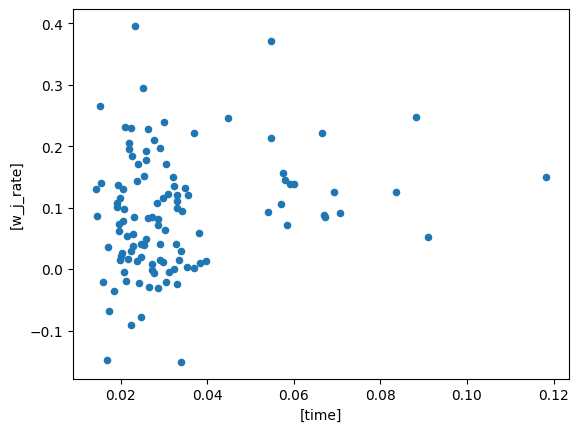

In [132]:
df.plot(['time'],['w_j_rate'],'scatter')

In [11]:
df_time_ij

dst_jcode,08220,08224,08235,11203,11204,11205,11208,11219,11220,11221,...,14135,14136,14137,14204,14205,14207,14209,14213,14215,14216
ori_jcode,,,,,,,,,,,,,,,,,,,,,
08220,0.016507,0.041667,0.020833,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,...,0.083333,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000
08224,0.020833,0.009514,0.020833,0.375000,0.375000,0.375000,0.375000,0.104167,0.375000,0.375000,...,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000
08235,0.020833,0.020833,0.004167,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,...,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000
11203,0.375000,0.375000,0.375000,0.041667,0.033736,0.041667,0.375000,0.375000,0.026667,0.375000,...,0.062500,0.375000,0.375000,0.111111,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000
11204,0.375000,0.375000,0.375000,0.043181,0.019076,0.020354,0.027778,0.049465,0.017715,0.041667,...,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14207,0.375000,0.375000,0.375000,0.375000,0.094444,0.375000,0.375000,0.375000,0.096528,0.375000,...,0.375000,0.375000,0.375000,0.040111,0.031451,0.019722,0.026465,0.053465,0.043979,0.055556
14209,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,...,0.375000,0.375000,0.041667,0.375000,0.375000,0.023472,0.173847,0.042424,0.059292,0.082722
14213,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,...,0.045000,0.030097,0.041632,0.051389,0.031167,0.051215,0.051972,0.024278,0.035611,0.039951


In [64]:
df_scaler.to_csv('data/2020/scaler.csv', index=False)
df_param.to_csv('data/2020/param.csv', index=False)
df_merged[['jcode','w_j']].to_csv('data/2020/w_j.csv', index=False)

df_merged[['jcode']].to_csv('data/2020/jcode.csv')
df_merged[['jcode','p_i']].to_csv('data/2020/p_i.csv', index=False)
df_merged[['jcode','q_i']].to_csv('data/2020/q_i.csv', index=False)
df_merged[['jcode','Q_j']].to_csv('data/2020/Q_j.csv', index=False)
df_merged[['jcode','theta_i']].to_csv('data/2020/theta_i.csv', index=False)

df_Pi_ij.to_csv('data/2020/Pi_ij.csv')
df_n_ij.to_csv('data/2020/n_ij.csv')
df_time_ij.to_csv('data/2020/t_ij.csv')
df_cost_ij.to_csv('data/2020/tau_ij.csv')

In [49]:
df_time_ij.to_csv('data/simulation/t_ij_005.csv')

# 可視化

In [87]:
# 通勤人数の集計
df_commute_ij_agg = pd.DataFrame({
    'jcode': df_commute_ij.index,
    'residents': df_commute_ij.sum(axis=1, numeric_only=True).to_numpy(),
    'workers': df_commute_ij.sum(axis=0, numeric_only=True).to_numpy()
})

# 子供の数の集計
df_children_ij_agg = pd.DataFrame({
    'jcode': df_children_ij.index,
    'children_i': df_children_ij.sum(axis=1, numeric_only=True).to_numpy(),
    'children_j': df_children_ij.sum(axis=0, numeric_only=True).to_numpy(),
})

# 子供の数の平均
df_n_ij_agg = pd.DataFrame({
    'jcode': df_n_ij.index,
    'n_i_ave': df_n_ij[df_n_ij != 0].mean(axis=1, numeric_only=True).to_numpy(),
    'n_j_ave': df_n_ij[df_n_ij != 0].mean(axis=0, numeric_only=True).to_numpy(),
})

df_merged = df_merged.merge(df_commute_ij_agg, left_on='jcode_to', right_on='jcode', how='left').drop(columns=['jcode'])
df_merged = df_merged.merge(df_children_ij_agg, left_on='jcode_to', right_on='jcode', how='left').drop(columns=['jcode'])
df_merged = df_merged.merge(df_n_ij_agg, left_on='jcode_to', right_on='jcode', how='left').drop(columns=['jcode'])

In [88]:
gdf = gpd.read_file('data/setup_2000_2020/jcode.geojson')
gdf['jcode'] = gdf['jcode'].astype(str)
gdf = gdf.merge(df_merged, left_on='jcode', right_on='jcode_to', how='left').drop(columns=['jcode_to'])

In [89]:
from libs_QSM.Plot_gdf import plot_gdf

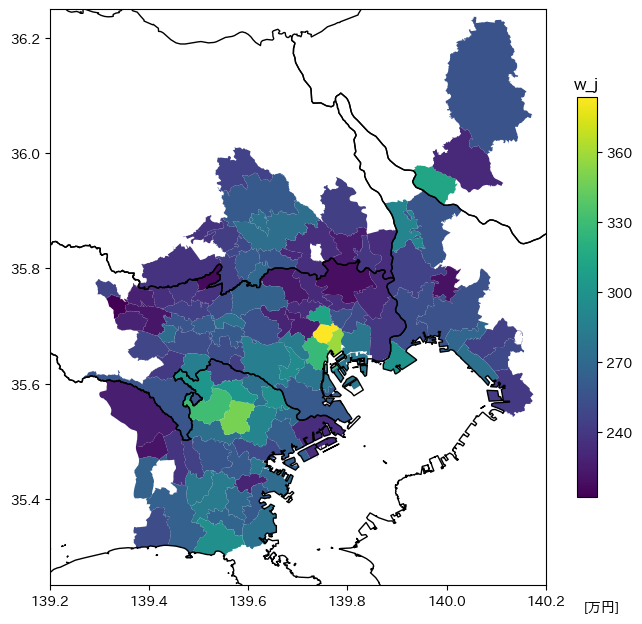

In [90]:
plot_gdf(gdf, '2020', 'w_j', '[万円]', lambda x, pos: int(x*300))

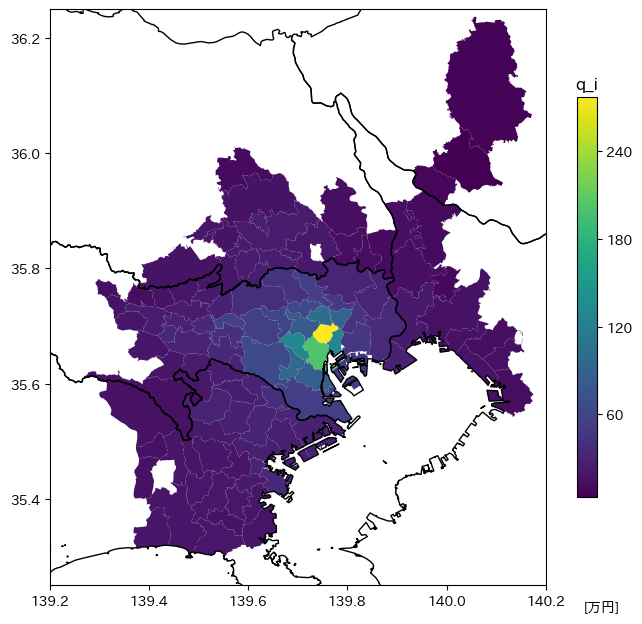

In [118]:
plot_gdf(gdf, '2020', 'q_i', '[万円]', lambda x, pos: int(x*30))

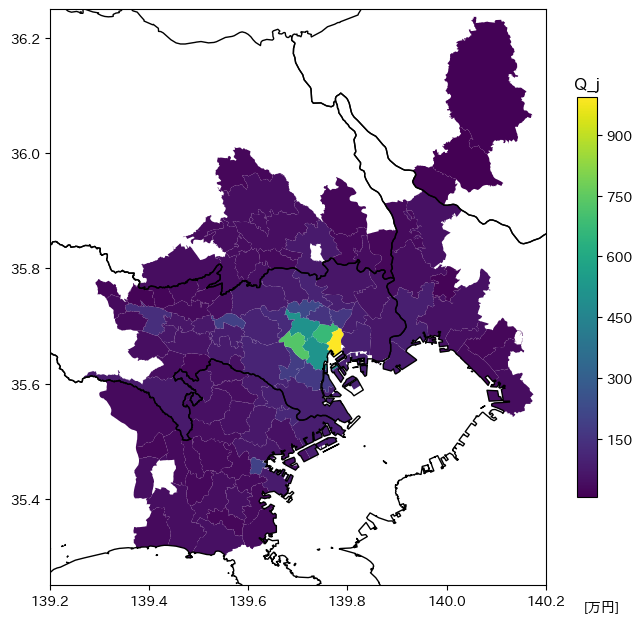

In [120]:
plot_gdf(gdf, '2020', 'Q_j', '[万円]', lambda x, pos: int(x*30))

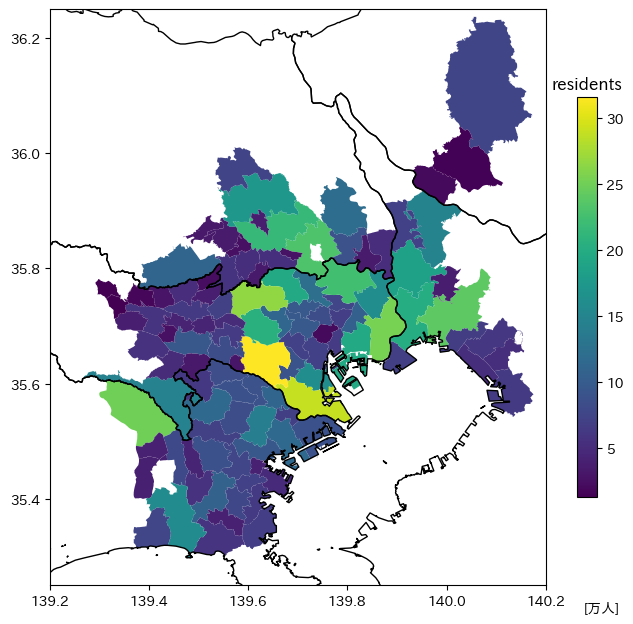

In [119]:
plot_gdf(gdf, '2020', 'residents', '[万人]', lambda x, pos: int(x/10000))

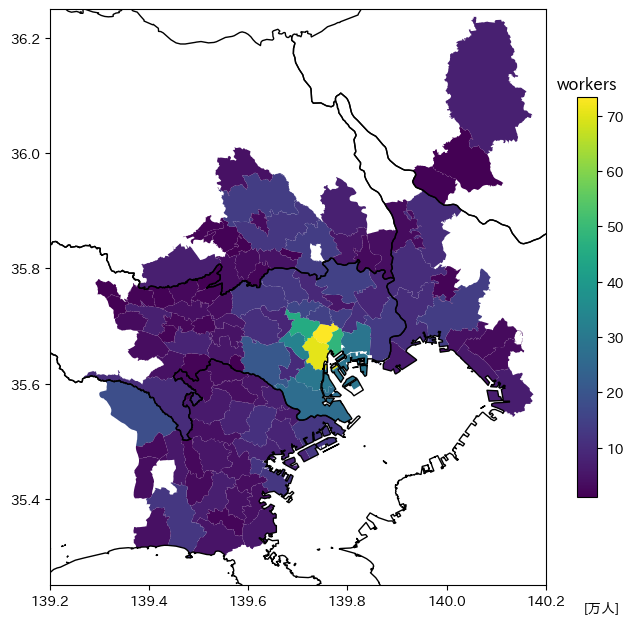

In [92]:
plot_gdf(gdf, '2020', 'workers', '[万人]', lambda x, pos: int(x/10000))

In [123]:
gdf['children_j'].std()

38579.07539113698

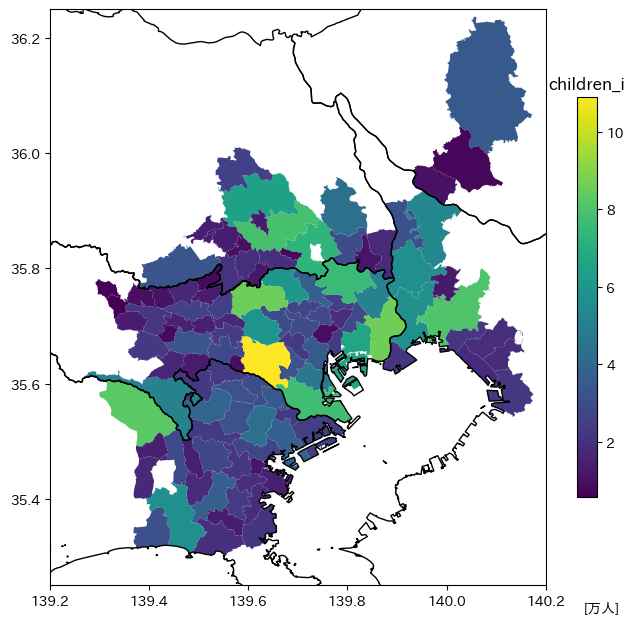

In [93]:
plot_gdf(gdf, '2020', 'children_i', '[万人]', lambda x, pos: int(x/10000))

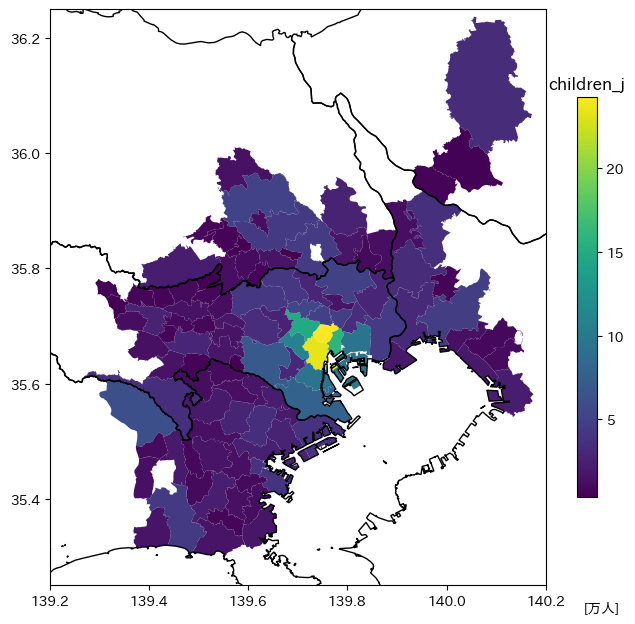

In [94]:
plot_gdf(gdf, '2020', 'children_j', '[万人]', lambda x, pos: int(x/10000))

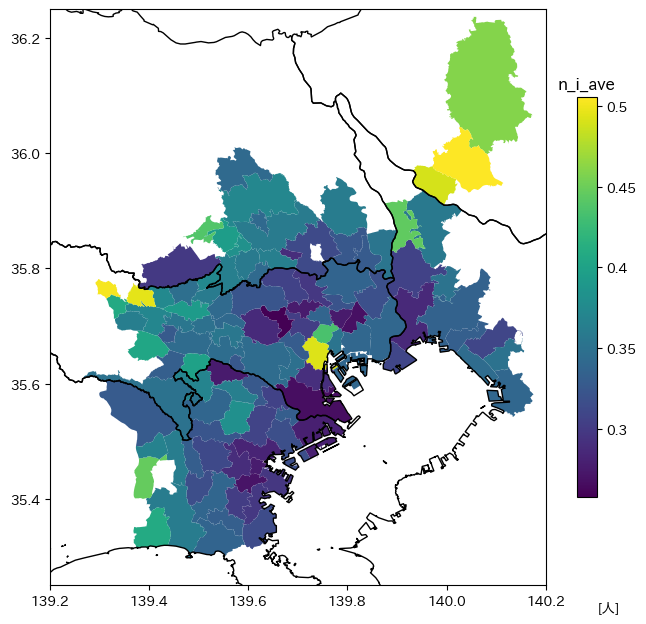

In [95]:
plot_gdf(gdf, '2020', 'n_i_ave', '[人]', lambda x, pos: x.round(2))

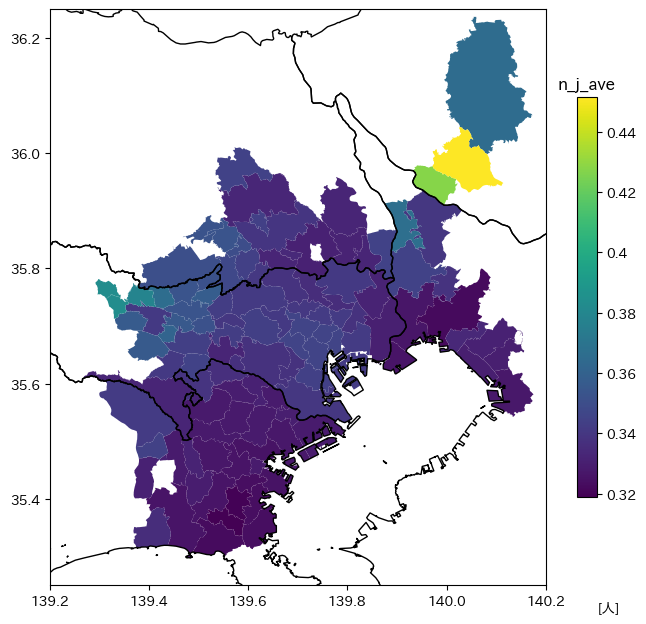

In [96]:
plot_gdf(gdf, '2020', 'n_j_ave', '[人]', lambda x, pos: x.round(2))

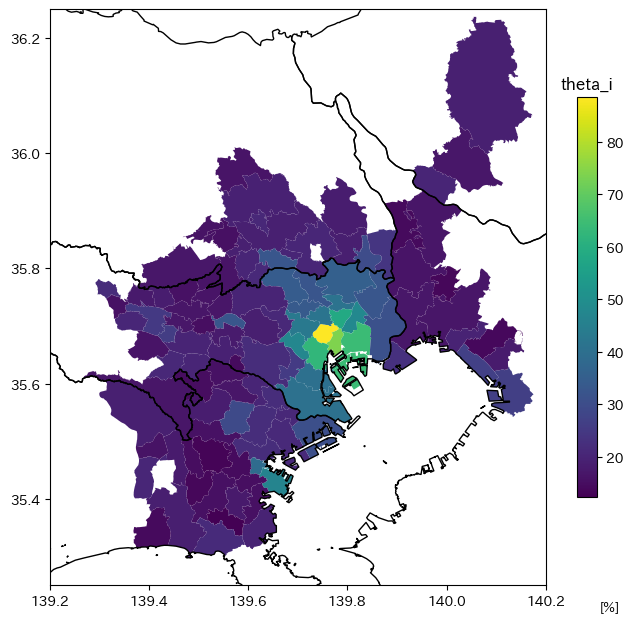

In [97]:
plot_gdf(gdf, '2020', 'theta_i', '[%]', lambda x, pos: int(x*100))